# Merge added buildings with tree canopy changes

Summarize the qualities of the tree canopy changes for the footprints of the added buildings.

In [1]:
import fiona
from pathlib import Path
import rasterio
import rasterio.mask
import numpy as np

In [2]:
buildings_added_shapefile = Path("building_added", "building_added.shp")

canopy_diff_rasterfile = Path("CanopyDiff.tif")

The new file we'll write merged data to

In [3]:
buildings_canopy_shapefile = Path("buildings_canopy", "buildings_canopy.shp")

buildings_canopy_shapefile.parent.mkdir(exist_ok=True)

In [4]:
canopy_diff_raster = rasterio.open(canopy_diff_rasterfile)

with fiona.open(buildings_added_shapefile) as source:
    schema = source.schema.copy()
    schema["properties"]["tree_sum"] = "float"
    print(schema)
    with fiona.open(buildings_canopy_shapefile, "w", 
                   driver=source.driver,
                   crs=source.crs,
                   schema=schema) as target:
        for index, feature in enumerate(source):
            if index % 100 == 0:
                print(index)
            properties = feature["properties"]
            geometry = feature["geometry"]
            geometries = [geometry] # rasterio wants a list of geometries
            
            # mask the raster using the feature's polygon(s)
            raster_image, out_transformation = rasterio.mask.mask(canopy_diff_raster,
                                                                  geometries,
                                                                  crop=True)
            
            # summarize the pixels in that raster image
            #print(raster_image)
            trees = np.float32(raster_image[0, :, :])
            
            # update the schema with the computed data
            properties["tree_sum"] = float(np.sum(trees))
            
            # write the row to the output file
            target.write({"properties": properties,
                         "geometry": geometry})

{'properties': OrderedDict([('OBJECTID', 'int:11'), ('BIN', 'str:7'), ('FCODE', 'int:6'), ('ADDRESS', 'str:39'), ('BUILDING_N', 'str:110'), ('BASE_ELEVA', 'float:32.10'), ('APPROX_HGT', 'int:6'), ('MAX_HGT', 'float:32.10'), ('PARCEL_ID_', 'str:10'), ('PARCEL_I_1', 'str:3'), ('SHAPE__ARE', 'float:32.10'), ('SHAPE__LEN', 'float:32.10'), ('tree_sum', 'float')]), 'geometry': 'Polygon'}
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700


Read the new shapefile and build a histogram

In [5]:
# from geopandas import GeoDataFrame as gdf
import geopandas as gpd

In [6]:
gdf = gpd.read_file(buildings_canopy_shapefile)

array([[<Axes: title={'center': 'tree_sum'}>]], dtype=object)

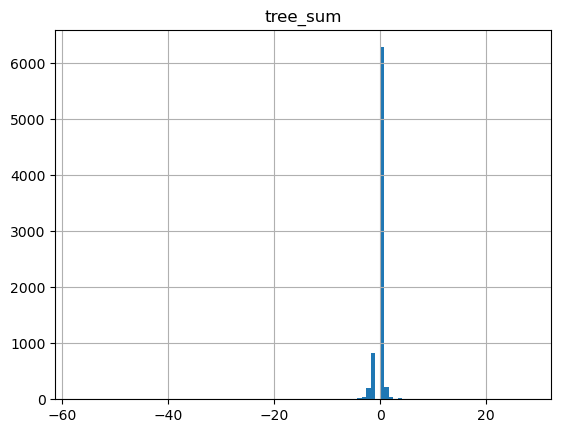

In [7]:
gdf.hist(column="tree_sum", bins=100)